In [1]:
import torch
import numpy as np
import numpy as np

## Data and Model Preparation

In [2]:
nr_samples = 100
dataset = torch.rand((nr_samples, 2))
labels_dataset = torch.sum(torch.square(dataset - torch.tensor([.5, .5])), dim=1) < .09

In [3]:
class DataLoader(object):
    def __init__(self,
                 data,
                 labels,
                 batch_size=1,
                 shuffle=True):
        
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return int(np.ceil(self.data.shape[0] / self.batch_size))

    def __iter__(self):
        n = self.data.shape[0]
        idxlist = list(range(n))
        if self.shuffle:
            np.random.shuffle(idxlist)

        for _, start_idx in enumerate(range(0, n, self.batch_size)):
            end_idx = min(start_idx + self.batch_size, n)
            data = self.data[idxlist[start_idx:end_idx]]
            labels = self.labels[idxlist[start_idx:end_idx]]
            yield data, labels
            
train_loader = DataLoader(dataset[:50], labels_dataset[:50], batch_size=64, shuffle=True)
test_loader = DataLoader(dataset[50:], labels_dataset[50:], batch_size=64, shuffle=False)

In [4]:
import torch.nn as nn 

class ModelA(nn.Module):
    def __init__(self):
        super(ModelA, self).__init__()
        self.elu = nn.ELU()
        self.layer1 = nn.Linear(2, 16)
        self.layer2 = nn.Linear(16, 16)
        self.layer3 = nn.Linear(16, 1)  # Output a single value per input
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.elu(self.layer1(x))
        x = self.elu(self.layer2(x))
        logits = self.layer3(x)
        probs = self.sigmoid(logits)
        return probs

    def predict(self, x):
        probs = self.forward(x)
        preds = (probs > 0.49999).float()
        return preds

    def compute_accuracy(self, data_loader):
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, labels in data_loader:
                preds = self.predict(data)
                predicted_labels = preds.squeeze()
                true_labels = labels.float()
                correct += (predicted_labels == true_labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        return accuracy

## My Implementation 

In [5]:
a = ModelA() 
a.compute_accuracy(train_loader)

0.74

In [6]:
a.compute_accuracy(test_loader)

0.64

In [7]:
import torch
from ltn_imp.fuzzy_operators.aggregators import SatAgg
from ltn_imp.parsing.parser import LTNConverter
from nltk.sem.logic import Expression

# Define the rules
expression_1 = "all x. ((y = pos) -> Classifier(x))"
expression_2 = "all x. ((y = neg) -> not Classifier(x))"

rules = [expression_1, expression_2]

# Initialize the satisfaction aggregator and optimizer
sat_agg = SatAgg()
optimizer = torch.optim.Adam(list(a.parameters()), lr=0.001)
converter = LTNConverter(predicates={"Classifier": a}, quantifier_impls={"forall": "pmean_error"})

# Convert the rules
rules = [converter(rule, process=False) for rule in rules]

log_steps = 400

# Training loop
for epoch in range(2001):
    results = []

    for batch in train_loader:
        data, label = batch

        # Convert labels to one-hot encoding
        label = torch.stack([torch.tensor([1., 0.]) if l == 1 else torch.tensor([0., 1.]) for l in label])

        # Create variable mapping for the entire batch
        var_mapping = {"x": data, "y": label, "pos": torch.tensor([1., 0.]), "neg": torch.tensor([0., 1.])}

        # Apply rules to the entire batch
        for rule in rules:
            results.append(rule(var_mapping))

    # Calculate the loss
    loss = 1- sat_agg(*results)

    # Ensure loss is a tensor and connected to the computation graph
    assert isinstance(loss, torch.Tensor), "Loss is not a tensor"
    assert loss.grad_fn is not None, "Loss has no grad_fn, indicating it is not connected to the computation graph"

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Logging
    if epoch % log_steps == 0:
        print([str(rule) for rule in rules])
        print("Results:", results)
        print("Loss:", loss)
        print()

['all x.((y = pos) -> Classifier(x))', 'all x.((y = neg) -> -Classifier(x))']
Results: [tensor(0.7181, grad_fn=<RsubBackward1>), tensor(0.6139, grad_fn=<RsubBackward1>)]
Loss: tensor(0.3380, grad_fn=<RsubBackward1>)

['all x.((y = pos) -> Classifier(x))', 'all x.((y = neg) -> -Classifier(x))']
Results: [tensor(0.6317, grad_fn=<RsubBackward1>), tensor(0.7710, grad_fn=<RsubBackward1>)]
Loss: tensor(0.3067, grad_fn=<RsubBackward1>)

['all x.((y = pos) -> Classifier(x))', 'all x.((y = neg) -> -Classifier(x))']
Results: [tensor(0.8625, grad_fn=<RsubBackward1>), tensor(0.8625, grad_fn=<RsubBackward1>)]
Loss: tensor(0.1375, grad_fn=<RsubBackward1>)

['all x.((y = pos) -> Classifier(x))', 'all x.((y = neg) -> -Classifier(x))']
Results: [tensor(0.9479, grad_fn=<RsubBackward1>), tensor(0.9443, grad_fn=<RsubBackward1>)]
Loss: tensor(0.0539, grad_fn=<RsubBackward1>)

['all x.((y = pos) -> Classifier(x))', 'all x.((y = neg) -> -Classifier(x))']
Results: [tensor(0.9842, grad_fn=<RsubBackward1>), ten

In [8]:
a.compute_accuracy(train_loader)

1.0

In [9]:
a.compute_accuracy(test_loader)

0.92

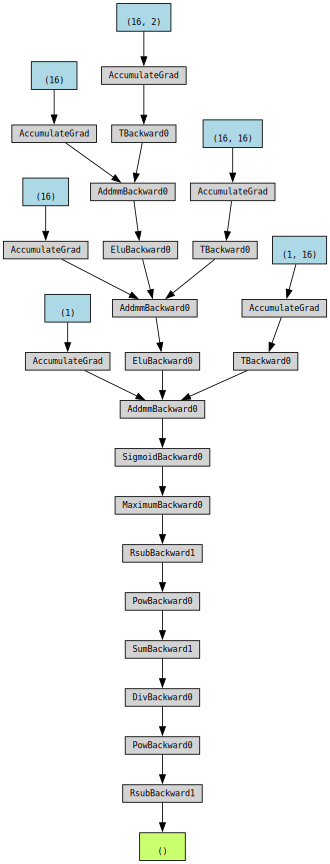

In [10]:
data, label = next(iter(test_loader))

# Convert labels to one-hot encoding
label = torch.stack([torch.tensor([1., 0.]) if l == 1 else torch.tensor([0., 1.]) for l in label])

# Create variable mapping for the entire batch
var_mapping = {"x": data, "y": label, "pos": torch.tensor([1., 0.]), "neg": torch.tensor([0., 1.])}

rules[0].comp_graph(var_mapping)